# 07. PyTorch Experiments Tracking

## Different ways to track experiments
* Python dictionaries, CSV files, print outs
* TensorBoard - https://www.tensorflow.org/tensorboard
* Weights & Biases - https://wandb.ai/site/experiment-tracking
* MLflow - https://mlflow.org/

## What is going to be covered in this module:
* Getting setup (importing previously written code)
* Introduce experiment tracking with PyTorch
* Building several modelling experiments for FoodVision Mini
* Evaluating modelling experiments with TensorBoard
* Making predictions with the best performing model on custom data

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.9.1+cu126
0.24.1+cu126


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """
    Sets random sets for torch operations.
    
    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [5]:
set_seeds()

## 1. Get Data

Run experiment tracking on FoodVision mini to see which model performs best

In [6]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

### 2.1 Create DataLoaders using manually created transforms

In [7]:
from going_modular.going_modular import data_setup

# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setupt ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manually created transform: {manual_transform}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform, # use manually created transforms
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

Manually created transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x233ab0f6e40>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

We can do this by first instantiating a set of pretrained weights (for example `weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT`) we'd like to use and calling the transforms() method on it.

In [8]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
effnetb2_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = effnetb2_weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x233ab0a3750>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freezing the base layers and changing the classifier 

Let's download the pretrained weights for a torchvision.models.efficientnet_b0() model and prepare it for use with our own data.

In [9]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
effnetb2_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=effnetb2_weights).to(device)

# View the output of the model
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Now we've got a pretrained model let's turn it into a feature extractor model.

In essence, we'll freeze the base layers of the model (we'll use these to extract features from our input images) and we'll change the classifier head (output layer) to suit the number of classes we're working with (we've got 3 classes: pizza, steak, sushi).

In [10]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

Base layers frozen, classifier head changed, let's get a summary of our model with `torchinfo.summary()`.

In [11]:
from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model and track results

Since we're working with multiple classes, we'll use [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the loss function.

And we'll stick with [`torch.optim.Adam()`](https://pytorch.org/docs/stable/optim.html) with learning rate of `0.001` for the optimizer

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Adjust `train()` function to track results with `SummaryWriter()`

We can use PyTorch's [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html) class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter.

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the `SummaryWriter()` are saved in [TensorBoard format](https://www.tensorflow.org/tensorboard/). TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default `SummaryWriter()` instance.

In [13]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print(f"[INFO] Couldn't find tensorboard...installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter
    
# Create a writer with all default settings
writer = SummaryWriter()

In [14]:
from going_modular.going_modular.engine import train_step, test_step

from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        writer.add_scalars(
            main_tag="Loss",
            tag_scalar_dict={"train_loss": train_loss, "test_loss": test_loss},
            global_step=epoch,
        )
        writer.add_scalars(
            main_tag="Accuracy",
            tag_scalar_dict={"train_acc": train_acc, "test_acc": test_acc},
            global_step=epoch,
        )
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    # Close the writer
    writer.close()
    ### End New:  Experiment tracking ###

    # Return the filled results at the end of the epochs
    return results

f:\Codes\pytorch-for-deep-learning-main\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Train model
# Note: not using engine.train(), since we updated the train() function above
set_seeds()
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9132 | test_acc: 0.5398


 20%|██        | 1/5 [00:48<03:14, 48.71s/it]

Epoch: 2 | train_loss: 0.8975 | train_acc: 0.6562 | test_loss: 0.7837 | test_acc: 0.8561


 40%|████      | 2/5 [01:46<02:42, 54.13s/it]

Epoch: 3 | train_loss: 0.8037 | train_acc: 0.7461 | test_loss: 0.6723 | test_acc: 0.8864


 60%|██████    | 3/5 [02:45<01:52, 56.22s/it]

Epoch: 4 | train_loss: 0.6770 | train_acc: 0.8516 | test_loss: 0.6698 | test_acc: 0.8049


 80%|████████  | 4/5 [03:47<00:58, 58.64s/it]

Epoch: 5 | train_loss: 0.7065 | train_acc: 0.7188 | test_loss: 0.6746 | test_acc: 0.7737


100%|██████████| 5/5 [04:45<00:00, 57.17s/it]


In [16]:
results

{'train_loss': [1.0923994481563568,
  0.8974788561463356,
  0.803712971508503,
  0.6769589930772781,
  0.7064888849854469],
 'train_acc': [0.3984375, 0.65625, 0.74609375, 0.8515625, 0.71875],
 'test_loss': [0.9132464528083801,
  0.7837385932604471,
  0.6722694436709086,
  0.6697843472162882,
  0.6746481855710348],
 'test_acc': [0.5397727272727273,
  0.8560606060606061,
  0.8863636363636364,
  0.8049242424242425,
  0.7736742424242425]}

## 5. View model's results with TensorBoard

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

| Code environment | How to view TensorBoard | Resource |
|------------------|-------------------------|----------|
|VS Code (notebooks or Python scripts)|Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard".|[VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration)|
|Jupyter and Colab Notebooks|Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`.|[`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started)

In [ ]:
# View the experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

## 6. Creat a function to prepare a `SummaryWriter()` instance

By default, the `SummaryWriter` class saves to `log_dir`.

How about if we wanted to save different experiments to different folders?

In essence, one experiment = one folder.

For example, we'd like to track:
* Experiment date/timestamp
* Experiment name
* Model name
* Extra - is there anything else that should be tracked?

Let's create a function to create a `SummaryWriter()` instance to take all of these things into account.

So ideally we end up tracking experiments to a directory

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [18]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str, model_name: str, extra: str = None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
    from datetime import datetime
    import os
    
    # Get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    print(f"[INFO] Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [19]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnet_b0",
                               extra="5_epochs"
                               )

example_writer

[INFO] Created SummaryWriter saving to runs\2026-01-21\data_10_percent\effnet_b0\5_epochs


### 6.1 Update the `train()` function to include a `writer` parameter

In [20]:
# Update train() to use create_writer()
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.going_modular.engine import train_step, test_step

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    writer: torch.utils.tensorboard.writer.SummaryWriter
) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        if writer:
            writer.add_scalars(
                main_tag="Loss",
                tag_scalar_dict={"train_loss": train_loss, "test_loss": test_loss},
                global_step=epoch,
            )
            writer.add_scalars(
                main_tag="Accuracy",
                tag_scalar_dict={"train_acc": train_acc, "test_acc": test_acc},
                global_step=epoch,
            )
            writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
            # Close the writer
            writer.close()
        else:
            pass
    ### End New:  Experiment tracking ###

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments

* Setup 2x modelling experiments with effnetb0, pizza, steak, sushi data and train one model for 5 epochs and another model for 10 epochs

### 7.1 What kind of experiments should be run?

The number of machine learning experiments you can run, is like the number of different models you can build... almost limitless.

However, you can't test everything...

So what should you test?

* Change the number of epochs
* Change the number of hidden layers/units
* Change the amount of data (right now we're using 10% of the Food101 dataset for pizza, steak, sushi)
* Change the learning rate
* Try different kinds of data augmentation
* Choose a different model architecture

This is why transfer learning is so powerful, because, it's a working model that you can apply to your own problem

### 7.2 What experiments are we going to run?

We're going to turn three dials:
1. Model size - EffnetB0 vs EffnetB2 (in terms of number of parameters)
2. Dataset size - 10% of pizza, steak, sushi images vs 20% (generally more data = better results)
3. Training time - 5 epochs vs 10 epochs (generally longer training time = better results, up to a point)

To begin, we're still keeping things relatively small so that our experiments run quickly

**Goal**: a model that is well performing but still small enough to run on a mobile device or web browser, so FoodVision Mini can come to life.

### 7.3 Donwload data

2 datasets:
1. Food101 10%
2. Food101 20%

In [21]:
# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                    destination="pizza_steak_sushi")
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


### 7.4 Transform Datasets and Create DataLoaders

We'll transform the data in a few ways:
1. Resize the images to (224, 224)
2. Make sure image tensor values are between [0, 1]
3. Normalize the images so they have the same data distribution as ImageNet

In [22]:
# setup training directory path
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# setup test directory
test_dir = data_10_percent_path / "test"  # using the same test set for both experiments

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [23]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Compose transforms into pipeline
simple_transform = transforms.Compose([
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize])

In [24]:
BATCH_SIZE = 32

# Create 10% training and testing DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform,
                                                                               batch_size=BATCH_SIZE)


# Create 20% training and testing DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform,
                                                                               batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10% training: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% training: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% test: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in 10% training: 8
Number of batches of size 32 in 20% training: 15
Number of batches of size 32 in 10% test: 3
Class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

Two functions:
1. Creates a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB0).
2. Creates a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB2).

In [25]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [26]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    effnetb0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=effnetb0_weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [27]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [28]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()

[INFO] Created new effnetb2 model.
[INFO] Created new effnetb0 model.


In [29]:
summary(model=created_model_test_effnetb2, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [30]:
summary(model=created_model_test_effnetb0, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 8. Create experiments and setup training code

In [31]:
# Epoch list
num_epochs = [5, 10]

# Create models list
models = ["effnetb0", "effnetb2"]

# Create DataLoaders dict
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [32]:
%%time
from going_modular.going_modular.utils import save_model

# Set seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through each epochs
    for epochs in num_epochs:
        # Loop through each model name and create a new model instance
        for model_name in models:
            # Print out info:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Epochs: {epochs}")
            
            # Select and create the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            elif model_name == "effnetb2":
                model = create_effnetb2()
                
            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Train target model with target DataLoader and track experiment
            # Note: using train() rather than engine.train() since we updated train() above
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # Save the model to file so we can import it later if need be
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50+"\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs\2026-01-21\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678


 20%|██        | 1/5 [01:00<04:01, 60.41s/it]

Epoch: 2 | train_loss: 0.9416 | train_acc: 0.5586 | test_loss: 0.8404 | test_acc: 0.5492


 40%|████      | 2/5 [01:54<02:50, 56.98s/it]

Epoch: 3 | train_loss: 0.8285 | train_acc: 0.6914 | test_loss: 0.7337 | test_acc: 0.7841


 60%|██████    | 3/5 [02:56<01:58, 59.05s/it]

Epoch: 4 | train_loss: 0.7219 | train_acc: 0.7578 | test_loss: 0.6268 | test_acc: 0.8864


 80%|████████  | 4/5 [03:54<00:58, 58.53s/it]

Epoch: 5 | train_loss: 0.6032 | train_acc: 0.8867 | test_loss: 0.5945 | test_acc: 0.8759


100%|██████████| 5/5 [04:56<00:00, 59.28s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter saving to runs\2026-01-21\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 20%|██        | 1/5 [01:05<04:21, 65.29s/it]

Epoch: 2 | train_loss: 0.9089 | train_acc: 0.6406 | test_loss: 0.9073 | test_acc: 0.6619


 40%|████      | 2/5 [02:06<03:09, 63.13s/it]

Epoch: 3 | train_loss: 0.8453 | train_acc: 0.6797 | test_loss: 0.8130 | test_acc: 0.8153


 60%|██████    | 3/5 [03:16<02:12, 66.24s/it]

Epoch: 4 | train_loss: 0.7203 | train_acc: 0.8516 | test_loss: 0.6988 | test_acc: 0.9072


 80%|████████  | 4/5 [04:32<01:10, 70.01s/it]

Epoch: 5 | train_loss: 0.7274 | train_acc: 0.7461 | test_loss: 0.6509 | test_acc: 0.8968


100%|██████████| 5/5 [05:39<00:00, 67.89s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs\2026-01-21\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678


 10%|█         | 1/10 [01:09<10:21, 69.06s/it]

Epoch: 2 | train_loss: 0.9416 | train_acc: 0.5586 | test_loss: 0.8404 | test_acc: 0.5492


 20%|██        | 2/10 [02:15<08:58, 67.28s/it]

Epoch: 3 | train_loss: 0.8285 | train_acc: 0.6914 | test_loss: 0.7337 | test_acc: 0.7841


 30%|███       | 3/10 [03:24<07:58, 68.43s/it]

Epoch: 4 | train_loss: 0.7219 | train_acc: 0.7578 | test_loss: 0.6268 | test_acc: 0.8864


 40%|████      | 4/10 [04:28<06:40, 66.69s/it]

Epoch: 5 | train_loss: 0.6032 | train_acc: 0.8867 | test_loss: 0.5945 | test_acc: 0.8759


 50%|█████     | 5/10 [05:33<05:29, 65.97s/it]

Epoch: 6 | train_loss: 0.5470 | train_acc: 0.8750 | test_loss: 0.6072 | test_acc: 0.8258


 60%|██████    | 6/10 [06:41<04:25, 66.47s/it]

Epoch: 7 | train_loss: 0.6480 | train_acc: 0.7227 | test_loss: 0.6107 | test_acc: 0.8258


 70%|███████   | 7/10 [07:49<03:20, 66.97s/it]

Epoch: 8 | train_loss: 0.5016 | train_acc: 0.9180 | test_loss: 0.5529 | test_acc: 0.8968


 80%|████████  | 8/10 [08:55<02:13, 66.93s/it]

Epoch: 9 | train_loss: 0.4611 | train_acc: 0.8945 | test_loss: 0.5422 | test_acc: 0.8864


 90%|█████████ | 9/10 [09:59<01:06, 66.02s/it]

Epoch: 10 | train_loss: 0.5681 | train_acc: 0.7539 | test_loss: 0.4906 | test_acc: 0.8864


100%|██████████| 10/10 [11:05<00:00, 66.51s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter saving to runs\2026-01-21\data_10_percent\effnetb2\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610


 10%|█         | 1/10 [01:04<09:43, 64.88s/it]

Epoch: 2 | train_loss: 0.9089 | train_acc: 0.6406 | test_loss: 0.9073 | test_acc: 0.6619


 20%|██        | 2/10 [02:23<09:43, 72.89s/it]

Epoch: 3 | train_loss: 0.8453 | train_acc: 0.6797 | test_loss: 0.8130 | test_acc: 0.8153


 30%|███       | 3/10 [03:28<08:06, 69.47s/it]

Epoch: 4 | train_loss: 0.7203 | train_acc: 0.8516 | test_loss: 0.6988 | test_acc: 0.9072


 40%|████      | 4/10 [04:41<07:05, 70.87s/it]

Epoch: 5 | train_loss: 0.7274 | train_acc: 0.7461 | test_loss: 0.6509 | test_acc: 0.8968


 50%|█████     | 5/10 [05:48<05:46, 69.36s/it]

Epoch: 6 | train_loss: 0.6089 | train_acc: 0.7656 | test_loss: 0.6575 | test_acc: 0.8665


 60%|██████    | 6/10 [06:52<04:30, 67.67s/it]

Epoch: 7 | train_loss: 0.5998 | train_acc: 0.8164 | test_loss: 0.6047 | test_acc: 0.9280


 70%|███████   | 7/10 [08:00<03:23, 67.73s/it]

Epoch: 8 | train_loss: 0.5486 | train_acc: 0.8281 | test_loss: 0.6058 | test_acc: 0.8873


 80%|████████  | 8/10 [09:04<02:13, 66.56s/it]

Epoch: 9 | train_loss: 0.5174 | train_acc: 0.7891 | test_loss: 0.5694 | test_acc: 0.8769


 90%|█████████ | 9/10 [10:06<01:04, 64.93s/it]

Epoch: 10 | train_loss: 0.5073 | train_acc: 0.8203 | test_loss: 0.5605 | test_acc: 0.8977


100%|██████████| 10/10 [11:09<00:00, 67.00s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs\2026-01-21\data_20_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6545 | test_acc: 0.8655


 20%|██        | 1/5 [01:06<04:25, 66.40s/it]

Epoch: 2 | train_loss: 0.7022 | train_acc: 0.8063 | test_loss: 0.5733 | test_acc: 0.9072


 40%|████      | 2/5 [02:12<03:19, 66.41s/it]

Epoch: 3 | train_loss: 0.5836 | train_acc: 0.8375 | test_loss: 0.4959 | test_acc: 0.8977


 60%|██████    | 3/5 [03:18<02:12, 66.22s/it]

Epoch: 4 | train_loss: 0.4558 | train_acc: 0.8938 | test_loss: 0.4131 | test_acc: 0.9176


 80%|████████  | 4/5 [04:19<01:04, 64.15s/it]

Epoch: 5 | train_loss: 0.4514 | train_acc: 0.8958 | test_loss: 0.3819 | test_acc: 0.9280


100%|██████████| 5/5 [05:29<00:00, 65.87s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter saving to runs\2026-01-21\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5563 | test_loss: 0.7767 | test_acc: 0.8153


 20%|██        | 1/5 [01:04<04:19, 64.86s/it]

Epoch: 2 | train_loss: 0.7180 | train_acc: 0.7937 | test_loss: 0.6591 | test_acc: 0.8258


 40%|████      | 2/5 [02:07<03:11, 63.73s/it]

Epoch: 3 | train_loss: 0.5791 | train_acc: 0.8771 | test_loss: 0.5576 | test_acc: 0.9280


 60%|██████    | 3/5 [03:08<02:05, 62.52s/it]

Epoch: 4 | train_loss: 0.5310 | train_acc: 0.8354 | test_loss: 0.5136 | test_acc: 0.9280


 80%|████████  | 4/5 [04:20<01:06, 66.30s/it]

Epoch: 5 | train_loss: 0.4890 | train_acc: 0.8625 | test_loss: 0.4486 | test_acc: 0.9489


100%|██████████| 5/5 [05:29<00:00, 65.89s/it]


[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs\2026-01-21\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6545 | test_acc: 0.8655


 10%|█         | 1/10 [01:04<09:40, 64.46s/it]

Epoch: 2 | train_loss: 0.7022 | train_acc: 0.8063 | test_loss: 0.5733 | test_acc: 0.9072


 20%|██        | 2/10 [02:14<09:02, 67.81s/it]

Epoch: 3 | train_loss: 0.5836 | train_acc: 0.8375 | test_loss: 0.4959 | test_acc: 0.8977


 30%|███       | 3/10 [03:20<07:49, 67.13s/it]

Epoch: 4 | train_loss: 0.4558 | train_acc: 0.8938 | test_loss: 0.4131 | test_acc: 0.9176


 40%|████      | 4/10 [04:27<06:42, 67.02s/it]

Epoch: 5 | train_loss: 0.4514 | train_acc: 0.8958 | test_loss: 0.3819 | test_acc: 0.9280


 50%|█████     | 5/10 [05:33<05:33, 66.67s/it]

Epoch: 6 | train_loss: 0.4222 | train_acc: 0.8604 | test_loss: 0.3729 | test_acc: 0.9280


 60%|██████    | 6/10 [06:35<04:20, 65.05s/it]

Epoch: 7 | train_loss: 0.3849 | train_acc: 0.8583 | test_loss: 0.3362 | test_acc: 0.9280


 70%|███████   | 7/10 [07:37<03:11, 63.93s/it]

Epoch: 8 | train_loss: 0.3451 | train_acc: 0.8938 | test_loss: 0.3427 | test_acc: 0.9384


 80%|████████  | 8/10 [08:42<02:08, 64.25s/it]

Epoch: 9 | train_loss: 0.3723 | train_acc: 0.8917 | test_loss: 0.3383 | test_acc: 0.9280


 90%|█████████ | 9/10 [09:45<01:03, 63.86s/it]

Epoch: 10 | train_loss: 0.3593 | train_acc: 0.8938 | test_loss: 0.2789 | test_acc: 0.9176


100%|██████████| 10/10 [10:49<00:00, 65.00s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter saving to runs\2026-01-21\data_20_percent\effnetb2\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5563 | test_loss: 0.7767 | test_acc: 0.8153


 10%|█         | 1/10 [01:04<09:41, 64.61s/it]

Epoch: 2 | train_loss: 0.7180 | train_acc: 0.7937 | test_loss: 0.6591 | test_acc: 0.8258


 20%|██        | 2/10 [02:10<08:41, 65.20s/it]

Epoch: 3 | train_loss: 0.5791 | train_acc: 0.8771 | test_loss: 0.5576 | test_acc: 0.9280


 30%|███       | 3/10 [03:14<07:33, 64.77s/it]

Epoch: 4 | train_loss: 0.5310 | train_acc: 0.8354 | test_loss: 0.5136 | test_acc: 0.9280


 40%|████      | 4/10 [04:21<06:34, 65.74s/it]

Epoch: 5 | train_loss: 0.4890 | train_acc: 0.8625 | test_loss: 0.4486 | test_acc: 0.9489


 50%|█████     | 5/10 [05:28<05:30, 66.18s/it]

Epoch: 6 | train_loss: 0.3795 | train_acc: 0.9125 | test_loss: 0.4644 | test_acc: 0.8977


 60%|██████    | 6/10 [06:29<04:17, 64.44s/it]

Epoch: 7 | train_loss: 0.3519 | train_acc: 0.9313 | test_loss: 0.4162 | test_acc: 0.9384


 70%|███████   | 7/10 [07:35<03:14, 64.76s/it]

Epoch: 8 | train_loss: 0.3214 | train_acc: 0.9333 | test_loss: 0.4129 | test_acc: 0.9280


 80%|████████  | 8/10 [08:39<02:09, 64.53s/it]

Epoch: 9 | train_loss: 0.3428 | train_acc: 0.8896 | test_loss: 0.4319 | test_acc: 0.8674


 90%|█████████ | 9/10 [09:45<01:04, 64.99s/it]

Epoch: 10 | train_loss: 0.3791 | train_acc: 0.8604 | test_loss: 0.3736 | test_acc: 0.9489


100%|██████████| 10/10 [10:55<00:00, 65.56s/it]


[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: total: 1min 41s
Wall time: 1h 5min 40s


In [40]:
# See results on TensorBoard
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 53788), started 2:44:17 ago. (Use '!kill 53788' to kill it.)

## 9. Loading the best model and making predictions on Random images from the test set

The best performing model was:
* Model: EffNetB2
* Dataset: Pizza, Steak, Sushi 20%
* Epochs: 10

Best model filepath: `models/07_effnetb2_data_20_percent_10_epochs.pth`

In [44]:
# Setup best model filepath
best_model_filepath = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load in the saved state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_filepath))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

Goal: Create a FoodVision Mini model that performs well enough and is able to run on a mobile device/web browser.

In [45]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb2_model_size = Path(best_model_filepath).stat().st_size / (1024 * 1024)
print(f"EffNetB2 feature extractor model size: {effnetb2_model_size:.2f} MB")

EffNetB2 feature extractor model size: 29.84 MB


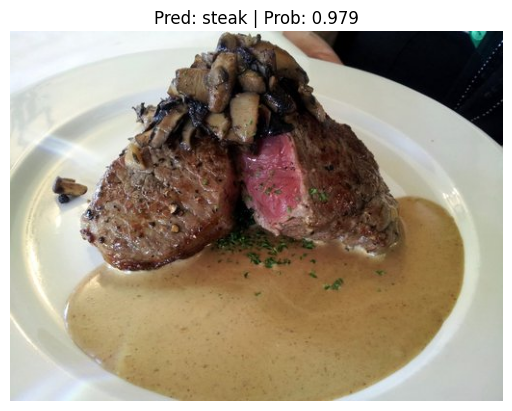

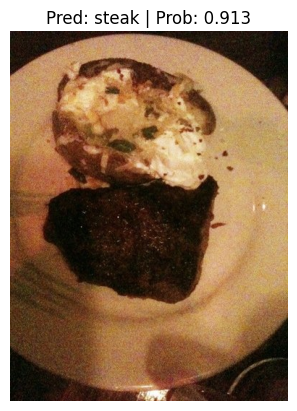

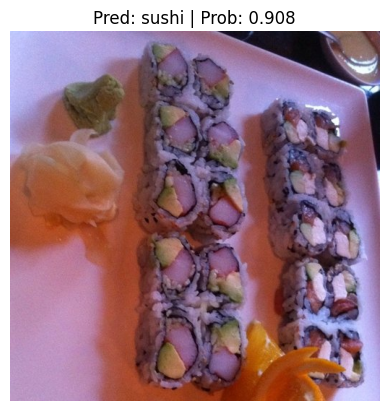

In [47]:
# Import function to make prediction on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))

### 9.1 Predict on a custom image with the best model

data\steak-pic.jpg already exists, skipping download.


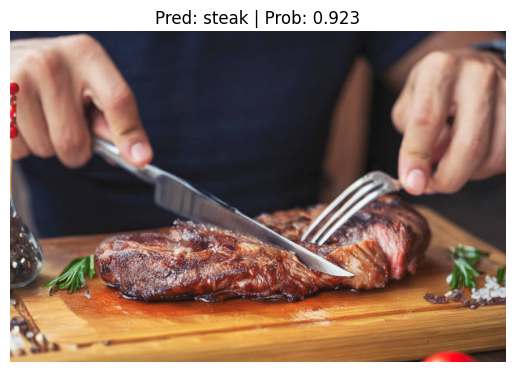

In [54]:
# Setup custom image path
data_path = Path("data")
custom_image_path = data_path / "steak-pic.jpg"

if custom_image_path.is_file():
    print(f"{custom_image_path} already exists, skipping download.")
    
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=simple_transform)